<a href="https://colab.research.google.com/github/laiamr/tfm/blob/main/Scripts/Pipeline_3_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas spacy matplotlib numpy

In [ ]:
import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re

In [ ]:
# Filenames
dataFile = "https://raw.githubusercontent.com/laiamr/tfm/refs/heads/main/Data/SocialMedia_Data.csv" # Contains the data
lexiconFile = "https://raw.githubusercontent.com/laiamr/tfm/refs/heads/main/Data/WordList.csv" # Contains information about the keywords we searched for in the tweets

In [ ]:
# Load data
df_in = pd.read_csv(dataFile, sep=";")
print(df_in.shape)
df_in.head()

(2909, 7)


,id,searchQuery,text,timestamp,cleanText,foundWord,socialMediaSense
0,1620116848825217024,retuit,et segueixo i no puc fer retuit a les teves pi...,2023-01-30 17:48:00+00:00,et segueixo i no puc fer retuit a les teves pi...,retuit,1
1,1652264071687806977,tuits,sí.\nsolen ser tuits patrocinats. \nde pagament.,2023-04-29T10:50:00.000Z,sí. solen ser tuits patrocinats. de pagament.,tuits,1
2,1619801223661748226,comentat,amb quin mobil has comentat?,2023-01-29T20:54:00.000Z,amb quin mobil has comentat?,comentat,1
3,1718708884951409072,blocat,fent mongetes i de cap al compte b q estic (or...,2023-10-29T19:18:00.000Z,fent mongetes i de cap al compte b q estic (or...,blocat,1
4,1620159160997355520,tuit,no passa res... un tuit i a dormir.\nfeina fet...,2023-01-30 20:36:00+00:00,no passa res... un tuit i a dormir. feina feta...,tuit,1


In [ ]:
# Load lexicon file
df_lex = pd.read_csv(lexiconFile, sep=";")
print(df_lex.shape)
df_lex.head()

(117, 7)


,original_lemma,loanword_lemma,loanword_form,loanword_pos,loanword_features,loanword_type,loanword_category
0,comment,comment,comment,"noun, verb",lemma,direct borrowing,foreign lexeme
1,tag,tag,tag,"noun, verb",lemma,direct borrowing,foreign lexeme
2,tag,tag,tags,noun,plural,direct borrowing,foreign lexeme
3,story,story,story,noun,lemma,direct borrowing,foreign lexeme
4,like,like,like,"noun, verb",lemma,direct borrowing,foreign lexeme


In [ ]:
# Add the type of loanword for each word of the dataset
df = pd.merge(df_in, df_lex, left_on='foundWord', right_on='loanword_form', how='left')
print(df.shape)
df.head()

(2909, 14)


,id,searchQuery,text,timestamp,cleanText,foundWord,socialMediaSense,original_lemma,loanword_lemma,loanword_form,loanword_pos,loanword_features,loanword_type,loanword_category
0,1620116848825217024,retuit,et segueixo i no puc fer retuit a les teves pi...,2023-01-30 17:48:00+00:00,et segueixo i no puc fer retuit a les teves pi...,retuit,1,retweet,retuit,retuit,noun,singular,full adaptation,foreign lexeme
1,1652264071687806977,tuits,sí.\nsolen ser tuits patrocinats. \nde pagament.,2023-04-29T10:50:00.000Z,sí. solen ser tuits patrocinats. de pagament.,tuits,1,tweet,tuit,tuits,noun,plural,full adaptation,foreign lexeme
2,1619801223661748226,comentat,amb quin mobil has comentat?,2023-01-29T20:54:00.000Z,amb quin mobil has comentat?,comentat,1,comment,comentar,comentat,verb,participle,calque,native lexeme
3,1718708884951409072,blocat,fent mongetes i de cap al compte b q estic (or...,2023-10-29T19:18:00.000Z,fent mongetes i de cap al compte b q estic (or...,blocat,1,block,blocar,blocat,verb,participle,calque,native lexeme
4,1620159160997355520,tuit,no passa res... un tuit i a dormir.\nfeina fet...,2023-01-30 20:36:00+00:00,no passa res... un tuit i a dormir. feina feta...,tuit,1,tweet,tuit,tuit,noun,singular,full adaptation,foreign lexeme


**TOKENISE AND POS TAG**

In [ ]:
# Annotate all the tweets with POS tags
# Load spacy model for Catalan
nlp = spacy.load("ca_core_news_md")

In [ ]:
# Function to save tokens and POS tags into lists
def tokenize_and_pos_tag(text: str) -> tuple:
    tokens = []
    pos_tags = []
    doc = nlp(text)

    for tok in doc:
        tokens.append(tok.text)
        pos_tags.append(tok.pos_.lower())

    return tokens, pos_tags

In [ ]:
# Apply tokenizer to the rows of data and save tokens and POS tags into two lists (and add them to the dataframe)
tokenized = []
pos_tags = []
for _, row in df.iterrows():
    a, b = tokenize_and_pos_tag(row['cleanText'])
    tokenized.append(a)
    pos_tags.append(b)

df['tokenized'] = tokenized
df['pos_tags'] = pos_tags

In [ ]:
# Function to extract the POS tag of a given word in the text
def get_pos_tag(word: str, tok_text: tuple, pos_tags: tuple) -> str:
    # Find index of the word in the tokenized list and then use the index to find the value in the pos_tags list
    try:
        idx = tok_text.index(word)
        tag = pos_tags[idx]
    except:
        tag = ''
    return tag

In [ ]:
# Apply the function to the dataframe to extract the POS tag of the target word (foundWord) in the text, for each row
df['detected_pos'] = df.apply(lambda row: get_pos_tag(row['foundWord'], row['tokenized'], row['pos_tags']), axis=1)
print(df.shape)
df.head()

**ANALYSE VOLUME OF DATA BY DATE**

In [ ]:
# Validate if all the tweets belong to the year 2023 (no, 2 of them are from 2022)
df[~df['timestamp'].str.startswith('2023')].shape

(2, 17)

In [ ]:
# Extract the year and month from the timestamp
df['year_month'] = df['timestamp'].str[:7]

In [ ]:
# Create the count of each timestamp to make a plot (remove duplicates and sort them)
count_timestamps = Counter(df.drop_duplicates(subset=['id'])['year_month'])
sorted_count_timestamps = dict(sorted(count_timestamps.items()))
print(sorted_count_timestamps)
dates_labels = list(sorted_count_timestamps.keys())
print(dates_labels)
dates_values = list(sorted_count_timestamps.values())
print(dates_values)

{'2022-07': 1, '2023-01': 1012, '2023-02': 1, '2023-03': 1, '2023-04': 469, '2023-07': 573, '2023-10': 408}
['2022-07', '2023-01', '2023-02', '2023-03', '2023-04', '2023-07', '2023-10']
[1, 1012, 1, 1, 469, 573, 408]


Text(0, 0.5, 'Number of tweets')

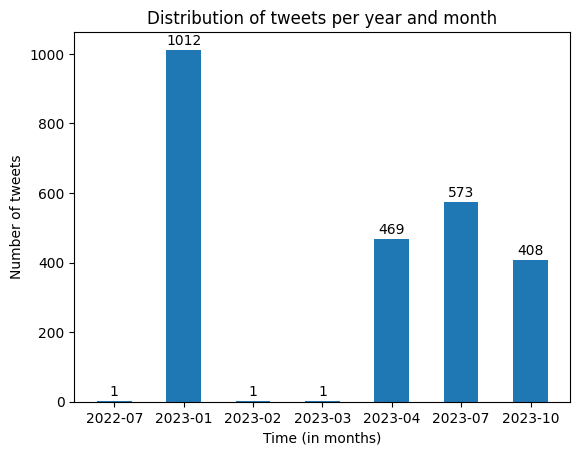

In [ ]:
# Create a bar chart to visualize the distribution of tweets per year and month
fig, ax = plt.subplots()
ax.bar(dates_labels, dates_values, width=0.5)
for i in range(len(dates_labels)):
        plt.text(i, dates_values[i]+15, dates_values[i], ha='center')
plt.title("Distribution of tweets per year and month")
plt.xlabel("Time (in months)")
plt.ylabel("Number of tweets")

**ANALYSE DATA BY TYPES OF BORROWING**

In [ ]:
# Extract the types of loanwords and their counts
count_types_borrowing = Counter(df['loanword_type'])
count_types_borrowing = dict(sorted(count_types_borrowing.items(), key=lambda item: item[1], reverse=True))
count_types_borrowing

{'calque': 1883,
 'full adaptation': 482,
 'direct borrowing': 368,
 'semantic extension': 168,
 'syntactic composition': 8}

Text(0, 0.5, 'Counts')

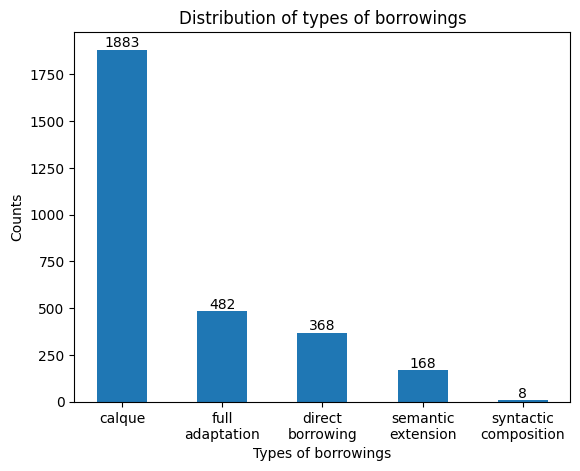

In [ ]:
# Extract the labels and counts of the types of borrowings for the plot
types_labels = list(count_types_borrowing.keys())
types_values = list(count_types_borrowing.values())
# Change each space in the labels for a new line (to fit well into the plot)
type_lab_wrapped = [lab.replace(' ', '\n') for lab in types_labels]

# Create a bar chart to show the distribution of types of borrowings, ordered by their counts
fig, ax = plt.subplots()
ax.bar(type_lab_wrapped, types_values, width=0.5)
for i in range(len(type_lab_wrapped)):
        plt.text(i, types_values[i]+15, types_values[i], ha='center')
plt.title("Distribution of types of borrowings")
plt.xlabel("Types of borrowings")
plt.ylabel("Counts")

Text(0.5, 1.0, 'Distribution of types of borrowings in percentages')

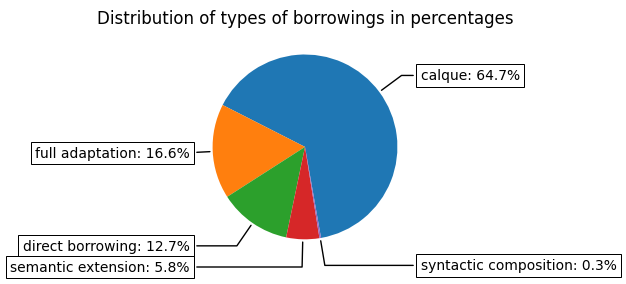

In [ ]:
# Create a pie chart to show the distribution of types of borrowings in percentages
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

def percentage(val, allvals):
    absolute = np.round(val*100./float(np.sum(allvals)),decimals=1)
    return f"{absolute:.1f}%"

types_percent = [percentage(val, types_values) for val in types_values]

wedges, texts = ax.pie(types_values,pctdistance=0.8, startangle=-80)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(f'{types_labels[i]}: {types_percent[i]}', xy=(x, y), xytext=(1.25*np.sign(x), 1.3*y),
                horizontalalignment=horizontalalignment, **kw)
plt.title("Distribution of types of borrowings in percentages")

**ANALYSE DATA BY 2 GROUPS: ORIGINAL WORD (FOREIGN LEXEME) VS TRANSLATION (NATIVE LEXEME)**

Text(0.0, 1.5, 'Distribution of categories of borrowings')

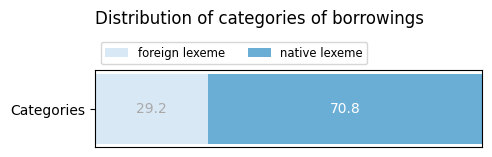

In [ ]:
# Count the percentage of each category of loanwords
# Foreign lexemes: the lexemes do not exist in Catalan (foreign origin)
# Native lexemes: the lexemes exist in Catalan (native origin)
counter_categories = Counter(df['loanword_category'])
category_labels = list(counter_categories.keys())
category_values = list(counter_categories.values())

# Adapt the data for the plot
def percentage(val, allvals):
    absolute = np.round(val*100./float(np.sum(allvals)),decimals=1)
    return absolute

category_percent = np.array([percentage(val, category_values) for val in category_values])

data_cum = category_percent.cumsum()
category_colors = plt.colormaps['Blues'](
        np.linspace(0.15, 0.5, len(category_percent)))
def percentage(val, allvals):
    absolute = np.round(val*100./float(np.sum(allvals)),decimals=1)
    return f"{absolute:.1f}%"

# Plot a horizontal bar chart with the categories of loanwords and their percentages
fig, ax = plt.subplots(figsize=(5, 1))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, 100)

for i, (colname, color) in enumerate(zip(category_labels, category_colors)):
    widths = category_percent[i]
    starts = data_cum[i] - widths
    rects = ax.barh('Categories', widths, left=starts, height=0.5,
                    label=colname, color=color)

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_labels), bbox_to_anchor=(0, 1),
            loc='lower left', fontsize='small')
plt.title('Distribution of categories of borrowings', y=1.5, loc='left')

**ANALYSE DATA BY: FULL ADAPTATION VS DIRECT BORROWING (NO CASES FOUND OF PARTIAL ADAPTATION)**

In [ ]:
# Count the types of loanwords in the foreign lexeme category
foreign_lex = Counter(df[df['loanword_category'] == 'foreign lexeme']['loanword_type'])
foreign_lex

Counter({'full adaptation': 482, 'direct borrowing': 368})

In [ ]:
# Print the percentage of each type of loanword in the foreign lexeme category
print(r'% Full adaptations:', np.round(foreign_lex['full adaptation']*100/np.sum(list(foreign_lex.values())), decimals=1))
print(r'% Direct borrowings:', np.round(foreign_lex['direct borrowing']*100/np.sum(list(foreign_lex.values())), decimals=1))

% Full adaptations: 56.7
% Direct borrowings: 43.3


**ANALYSE DATA BY: CALQUE VS SEMANTIC EXTENSION**

In [ ]:
# Count the types of loanwords in the native lexeme category
native_categ = Counter(df[df['loanword_category'] == 'native lexeme']['loanword_type'])
native_categ

Counter({'calque': 1883,
         'semantic extension': 168,
         'syntactic composition': 8})

In [ ]:
# Print the percentages of each type of loanword in the native lexeme category
print(r'% Calques:', np.round(native_categ['calque']*100/np.sum(list(native_categ.values())), decimals=1))
print(r'% Semantic extensions:', np.round(native_categ['semantic extension']*100/np.sum(list(native_categ.values())), decimals=1))
print(r'% Syntactic compositions:', np.round(native_categ['syntactic composition']*100/np.sum(list(native_categ.values())), decimals=1))

% Calques: 91.5
% Semantic extensions: 8.2
% Syntactic compositions: 0.4


**CASE STUDY 1: DEGREE OF ADHERENCE TO THE NORM (TERMCAT)**

TermCat claims that, whenever possible, the order of preference when incorporating a new word into the language should be:
1. Catalan alternative - semantic extension & syntactic composition
2. Adaptation
3. Calque
4. Direct borrowing

In [ ]:
# Our types of borrowings
count_types_borrowing = Counter(df['loanword_type'])
count_types_borrowing

Counter({'calque': 1883,
         'full adaptation': 482,
         'direct borrowing': 368,
         'semantic extension': 168,
         'syntactic composition': 8})

In [ ]:
# Create a classification following TermCat's proposal
# Join semantic extension and syntactic composition into "Catalan alternatives", leave the rest as they are
termcat_categ_borrowings = {}
termcat_categ_borrowings['Catalan alternatives'] = count_types_borrowing['semantic extension'] + count_types_borrowing['syntactic composition']
termcat_categ_borrowings['Adaptations'] = count_types_borrowing['full adaptation']
termcat_categ_borrowings['Calques'] = count_types_borrowing['calque']
termcat_categ_borrowings['Direct borrowings'] = count_types_borrowing['direct borrowing']

Text(0, 0.5, 'Counts')

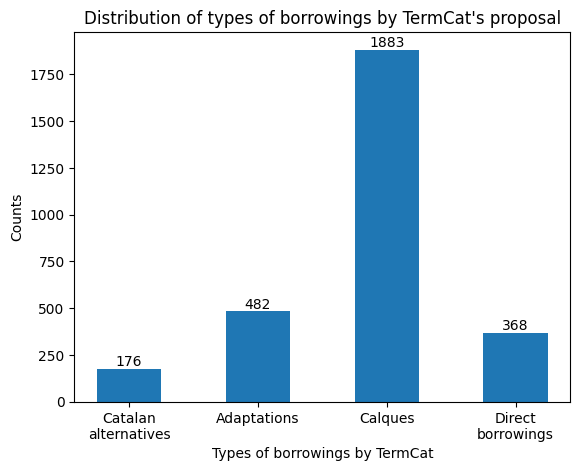

In [ ]:
# Change each space in the labels for a new line (to fit well into the plot)
termcat_labels = list(termcat_categ_borrowings.keys())
termcat_lab_wrapped = [lab.replace(' ', '\n') for lab in termcat_labels]
termcat_values = list(termcat_categ_borrowings.values())

# Plot a bar chart with the distribution of types of borrowings according to TermCat's proposal (by order of preference)
fig, ax = plt.subplots()
ax.bar(termcat_lab_wrapped, termcat_values, width=0.5)
for i in range(len(termcat_lab_wrapped)):
        plt.text(i, termcat_values[i]+15, termcat_values[i], ha='center')
plt.title("Distribution of types of borrowings by TermCat's proposal")
plt.xlabel("Types of borrowings by TermCat")
plt.ylabel("Counts")

Text(0.0, 1.75, 'Types of borrowings by TermCat')

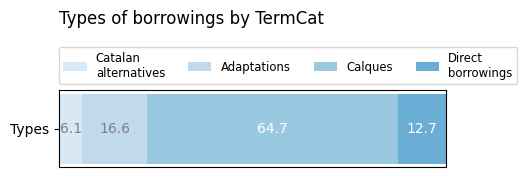

In [ ]:
# Adapt the data for the plot
def percentage(val, allvals):
    absolute = np.round(val*100./float(np.sum(allvals)),decimals=1)
    return absolute

category_percent = np.array([percentage(val, termcat_values) for val in termcat_values])

data_cum = category_percent.cumsum()
category_colors = plt.colormaps['Blues'](
        np.linspace(0.15, 0.5, len(category_percent)))
def percentage(val, allvals):
    absolute = np.round(val*100./float(np.sum(allvals)),decimals=1)
    return f"{absolute:.1f}%"

# Plot a horizontal bar chart with the categories of loanwords and their percentages
fig, ax = plt.subplots(figsize=(5, 1))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, 100)

for i, (colname, color) in enumerate(zip(termcat_lab_wrapped, category_colors)):
    widths = category_percent[i]
    starts = data_cum[i] - widths
    rects = ax.barh('Types', widths, left=starts, height=0.5,
                    label=colname, color=color)

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'grey'
    ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(termcat_lab_wrapped), bbox_to_anchor=(-0.015, 1),
            loc='lower left', fontsize='small')
plt.title('Types of borrowings by TermCat', y=1.75, loc='left')

**ANALYSE: LIGHT VERB CONSTRUCTIONS**

options:<br>
INF/PART/GER + Det + Noun_sing<br>
INF/PART/GER + Noun_pl

light verbs: fer, donar, deixar

First approach for extracting light verb constructions (deprecated)

In [ ]:
# Extract light verb constructions from the tweets using regular expressions and a predefined list of light verbs
# The light verbs we are interested in are: fer, donar, and deixar, in the different non-finite forms (inf, gerund, masc sing participle)
# Not the best strategy

constructions = []

# Iterate over each row of the dataframe to search the text
for _, row in df.iterrows():

    # Since we searched for all word in all the tweets, the texts that contain more than one word will be duplicated
    # No need to search for all words in each tweet, only the foundWord
    word = row['foundWord']
    text = row['cleanText']

    # Define the pattern and search for it in the text
    pattern = r'(?:^|[ !-\/:-?[-`{-~])((?:fer|fet|fent|donar|donat|donant|deixar|deixat|deixant)(?: \w+\b)?\b ' + word + ')'
    matches = re.findall(pattern, text)

    # Remove the 'deixar/deixat/deixant de seguir' construction, since it is not a light verb construction
    matches = [i for i in matches if i not in ['deixar de seguir', 'deixat de seguir', 'deixant de seguir']]

    # Check if there are results
    if len(matches) > 0:
        constructions.extend(matches) # the variable matches is a list, we want all the values in the same level, not a list of lists, so we use extend instead of append


In [ ]:
print('Total constr:', len(constructions))
unique_light_verb_constr = list(set(constructions))
print('Unique constr:', len(unique_light_verb_constr))

Total constr: 98
Unique constr: 65


New approach for extracting light verb constructions

In [ ]:
# Get the rows with the nouns in our list of words
df_nouns = df[(df['loanword_pos'].str.contains('noun')) & (df['detected_pos'].isin(['noun', '', 'propn']))]
print(df_nouns.shape)
df_nouns.head()

(1842, 18)


,id,searchQuery,text,timestamp,cleanText,foundWord,socialMediaSense,original_lemma,loanword_lemma,loanword_form,loanword_pos,loanword_features,loanword_type,loanword_category,tokenized,pos_tags,detected_pos,year_month
0,1620116848825217024,retuit,et segueixo i no puc fer retuit a les teves pi...,2023-01-30 17:48:00+00:00,et segueixo i no puc fer retuit a les teves pi...,retuit,1,retweet,retuit,retuit,noun,singular,full adaptation,foreign lexeme,"[et, segueixo, i, no, puc, fer, retuit, a, les...","[pron, verb, cconj, adv, aux, verb, noun, adp,...",noun,2023-01
1,1652264071687806977,tuits,sí.\nsolen ser tuits patrocinats. \nde pagament.,2023-04-29T10:50:00.000Z,sí. solen ser tuits patrocinats. de pagament.,tuits,1,tweet,tuit,tuits,noun,plural,full adaptation,foreign lexeme,"[sí, ., solen, ser, tuits, patrocinats, ., de,...","[adv, punct, verb, aux, noun, adj, punct, adp,...",noun,2023-04
4,1620159160997355520,tuit,no passa res... un tuit i a dormir.\nfeina fet...,2023-01-30 20:36:00+00:00,no passa res... un tuit i a dormir. feina feta...,tuit,1,tweet,tuit,tuit,noun,singular,full adaptation,foreign lexeme,"[no, passa, res, ..., un, tuit, i, a, dormir, ...","[adv, verb, pron, punct, det, noun, cconj, adp...",noun,2023-01
5,1619992121070743552,missatge directe,"hola sílvia, hem vist el teu tuit. ens pots ex...",2023-01-30 09:33:00+00:00,"hola sílvia, hem vist el teu tuit. ens pots ex...",missatge,1,message,missatge,missatge,noun,singular,calque,native lexeme,"[hola, sílvia, ,, hem, vist, el, teu, tuit, .,...","[propn, propn, punct, aux, verb, det, det, nou...",noun,2023-01
7,1718544104508838085,respostes,imaginem una ia que sigui capaç de simular les...,2023-10-29T08:23:00.000Z,imaginem una ia que sigui capaç de simular les...,respostes,1,reply,resposta,respostes,noun,plural,calque,native lexeme,"[imaginem, una, ia, que, sigui, capaç, de, sim...","[verb, det, noun, pron, aux, adj, adp, verb, d...",noun,2023-10


In [ ]:
# Function to find verbs on the left of the target nouns
# We only consider the verbs in the non-finite forms (infinitive, gerund, masculine singular participle), because they are the ones that we extracted the tweets for
# Other forms wouldn't be representative of the real distribution of data, since we didn't search for them
def find_light_verb_constructions(word: str, tok_text: tuple, pos_tags: tuple) -> list:
    # Find index of the word in the tokenized list and then use the index to find the value in the pos_tags list
    context = ''
    verb_form = ''
    lemma = ''
    lem_context = ''
    idx = 0
    try:
        # First, we tokenize the foundWord. E.g. "m'agrada" has 2 tokens -> ["m'", "agrada"]
        d = nlp(word)
        tok_word = [tok.text for tok in d]
        #print(tok_word)
        len_tok_word = len(tok_word)  # Number of tokens in the word

        # If the word has more than one token, we take the first one (e.g. "m'agrada" -> "m'")
        if len(tok_word) > 1:
            # Find the slice of the tokenized text that matches the word (list of tokens)
            for i in range(0, len(tok_text)-len_tok_word+1):
                slice = tok_text[i:i+len_tok_word]
                # If the slice matches the word, we take the index of the first token of the word
                if slice == tok_word:
                    idx = i
                    #print(f'idx = {idx}, slice = {slice}, tok_word = {tok_word}')
                    break
        else:
            # If the word has only one token, we find the index of the token in the tokenized text
            idx = tok_text.index(tok_word[0])
        #print(idx)

        # Now we have the indices of the tokens that match the word in the tokenized text
        # We take the left context of each instance of the word (given by the indices) - where the verb should be
        # But we only contemplate a small window of the left context, 3 tokens before the word
        ini = max(0, idx-3)  # Ensure we don't go out of bounds
        left_context = tok_text[ini:idx]
        #print(left_context)

        # We check the POS tags of the left context to find a verb
        # We could find a determiner in betweeen the verb and the target noun, or a punctuation mark. E.g: fer 'mute'
        for i in range(idx-1, ini, -1): # go backwards, from the end to the beginning of the context
            #print(i, left_context[i], pos_tags[i])
            # Check if the current token is a verb, a determiner, or a punctuation mark
            if pos_tags[i] == 'verb':
                # If we find a verb, stop and return a string from this position up to the target word
                context = " ".join(tok_text[i:idx]) + ' ' + word # include the target word (if we get the word from the slice, in the m'agrada case, there would be a space after the apostrophe)
                # Finally, we tokenize the context to make sure that the verb is in one of the non-finite forms we are interested in
                d = nlp(context)
                # We know the verb is in the first position because we stopped the search when we found it
                found_verb_forms = set(d[0].morph.get('VerbForm'))
                non_fin_forms = {'Inf', 'Ger', 'Part'}  # Non-finite forms we are interested in
                # Check if the verb is in one of the non-finite forms we are interested in (we intersect the two sets)
                form_inters = found_verb_forms.intersection(non_fin_forms)
                if form_inters: # intersection not empty
                    # If the verb is in one of the non-finite forms we are interested in, we keep the context
                    # and we return it together with its verb form, the lemma of the verb and the context with the verb lemmatized
                    verb_form = form_inters.pop()  # Get the first form in the intersection
                    lemma = d[0].lemma_
                    # Fin the position of the space after the verb in the context
                    pos_space = context.find(' ')
                    # We change the inflected verb for the lemma in the context
                    lem_context = lemma + context[pos_space:]
                else:
                    # If the verb is not in one of the non-finite forms we are interested in, we empty the context and lemma
                    context = ''
                break
            # Punctuation marks are only allowed if they are quotation marks
            elif pos_tags[i] == 'punct' and tok_text[i] not in ['"', "'", '“', '”']:
                # If we find a punctuation mark different from quotes, we stop the search
                break
            elif pos_tags[i] == 'det' or pos_tags[i] == 'adj':
                # If we find a determiner or adjective, we continue the search
                continue
            else:
                # If we find any other POS tag, we stop the search
                break

    except:
        # If we don't find any verb, we return an empty list
        pass
    #print(f'final context: {context} - lemma: {lemma}')
    return context, verb_form, lemma, lem_context

In [ ]:
# TESTING
id = 165 # 0, 23
word = df_nouns['foundWord'][id]
tok_text = df_nouns['tokenized'][id]
pos_tags = df_nouns['pos_tags'][id]

find_light_verb_constructions(word, tok_text, pos_tags)

('fer un tweet', 'Inf', 'fer', 'fer un tweet')

In [ ]:
# We apply the function to each row of the dataframe, passing the foundWord, tokenized text, and POS tags
# The function returns a tuple with the verb construction, the verb form, the lemma of the verb, and the lemma of the construction
for _, row in df_nouns.iterrows():
    constr, verb_form, lemma, lem_constr = find_light_verb_constructions(row['foundWord'], row['tokenized'], row['pos_tags'])
    df_nouns.at[_, 'verb_constr'] = constr
    df_nouns.at[_, 'verb_form'] = verb_form
    df_nouns.at[_, 'verb_lemma'] = lemma
    df_nouns.at[_, 'verb_lemma_constr'] = lem_constr

/var/folders/n5/fr7ssm7s57z_7psd2b6ddp9r0000gp/T/ipykernel_65516/2522837862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nouns.at[_, 'verb_constr'] = constr
/var/folders/n5/fr7ssm7s57z_7psd2b6ddp9r0000gp/T/ipykernel_65516/2522837862.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nouns.at[_, 'verb_form'] = verb_form
/var/folders/n5/fr7ssm7s57z_7psd2b6ddp9r0000gp/T/ipykernel_65516/2522837862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [ ]:
# Create a new dataframe with the verb constructions
df_verb_constr = df_nouns[df_nouns['verb_constr'] != '']
print(df_verb_constr.shape)
df_verb_constr.head()

(253, 22)


,id,searchQuery,text,timestamp,cleanText,foundWord,socialMediaSense,original_lemma,loanword_lemma,loanword_form,...,loanword_type,loanword_category,tokenized,pos_tags,detected_pos,year_month,verb_constr,verb_form,verb_lemma,verb_lemma_constr
0,1620116848825217024,retuit,et segueixo i no puc fer retuit a les teves pi...,2023-01-30 17:48:00+00:00,et segueixo i no puc fer retuit a les teves pi...,retuit,1,retweet,retuit,retuit,...,full adaptation,foreign lexeme,"[et, segueixo, i, no, puc, fer, retuit, a, les...","[pron, verb, cconj, adv, aux, verb, noun, adp,...",noun,2023-01,fer retuit,Inf,fer,fer retuit
7,1718544104508838085,respostes,imaginem una ia que sigui capaç de simular les...,2023-10-29T08:23:00.000Z,imaginem una ia que sigui capaç de simular les...,respostes,1,reply,resposta,respostes,...,calque,native lexeme,"[imaginem, una, ia, que, sigui, capaç, de, sim...","[verb, det, noun, pron, aux, adj, adp, verb, d...",noun,2023-10,simular les respostes,Inf,simular,simular les respostes
29,1718651703115842033,likes,puigdemontistes titllant de cunyat a ningú 🤣🤣🤣...,2023-10-29T15:31:00.000Z,puigdemontistes titllant de cunyat a ningú 🤣🤣🤣...,likes,1,like,like,likes,...,direct borrowing,foreign lexeme,"[puigdemontistes, titllant, de, cunyat, a, nin...","[adj, verb, adp, noun, adp, pron, pron, verb, ...",noun,2023-10,arreplegar likes,Inf,arreplegar,arreplegar likes
38,1652346629607903241,tuits,"sempre ho dic, tinc molta capacitat per escriu...",2023-04-29T16:18:00.000Z,"sempre ho dic, tinc molta capacitat per escriu...",tuits,1,tweet,tuit,tuits,...,full adaptation,foreign lexeme,"[sempre, ho, dic, ,, tinc, molta, capacitat, p...","[adv, pron, verb, punct, verb, det, noun, adp,...",noun,2023-04,escriure tuits,Inf,escriure,escriure tuits
66,1619962362446086144,tweet,ha arribat el dia de fer el titular cutre que ...,2023-01-30 07:34:00+00:00,ha arribat el dia de fer el titular cutre que ...,tweet,1,tweet,tweet,tweet,...,direct borrowing,foreign lexeme,"[ha, arribat, el, dia, de, fer, el, titular, c...","[aux, verb, det, noun, adp, verb, det, noun, a...",noun,2023-01,fer aquest tweet,Inf,fer,fer aquest tweet


In [ ]:
# Check if the lemma of the verb is correct: we look for the verbs that don't end with 'r' or 're'
# 15 verbs have the participle as the lemma, we'll manually correct them to avoid errors in the analysis
df_verb_constr[~(df_verb_constr['verb_lemma'].str.endswith('r')) & ~(df_verb_constr['verb_lemma'].str.endswith('re'))]

,id,searchQuery,text,timestamp,cleanText,foundWord,socialMediaSense,original_lemma,loanword_lemma,loanword_form,...,loanword_type,loanword_category,tokenized,pos_tags,detected_pos,year_month,verb_constr,verb_form,verb_lemma,verb_lemma_constr
331,1620151513384624128,etiqueta,"1. @tinavalles_ , hem recuperat uns tuits que ...",2023-01-30 20:06:00+00:00,"1. @tinavalles_ , hem recuperat uns tuits que ...",tuits,1,tweet,tuit,tuits,...,full adaptation,foreign lexeme,"[1, ., @tinavalles, _, ,, hem, recuperat, uns,...","[num, punct, adj, punct, punct, aux, verb, det...",noun,2023-01,recuperat uns tuits,Part,recuperat,recuperat uns tuits
504,1620182281238495232,missatge,té a veure amb el grup? pq he passat els missa...,2023-01-30 22:08:00+00:00,té a veure amb el grup? pq he passat els missa...,missatges,1,message,missatge,missatges,...,calque,native lexeme,"[té, a, veure, amb, el, grup, ?, pq, he, passa...","[verb, adp, noun, adp, det, noun, punct, pron,...",noun,2023-01,passat els missatges,Part,passat,passat els missatges
543,1619985377837862912,tweet,"he denunciat el tweet, però també cal tenir en...",2023-01-30 09:06:00+00:00,"he denunciat el tweet, però també cal tenir en...",tweet,1,tweet,tweet,tweet,...,direct borrowing,foreign lexeme,"[he, denunciat, el, tweet, ,, però, també, cal...","[aux, verb, det, noun, punct, cconj, adv, verb...",noun,2023-01,denunciat el tweet,Part,denunciat,denunciat el tweet
1005,1619705738989015041,tweet,no sabeu pas la il•lusió que m'ha fet que m'ha...,2023-01-29T14:35:00.000Z,no sabeu pas la il•lusió que m'ha fet que m'ha...,tweet,1,tweet,tweet,tweet,...,direct borrowing,foreign lexeme,"[no, sabeu, pas, la, il•lusió, que, m', ha, fe...","[adv, adj, noun, det, noun, pron, pron, aux, v...",noun,2023-01,respost aquest tweet,Part,respost,respost aquest tweet
1077,1619769508050403328,likes,"mai he fet tuits per tenir likes, sempre escri...",2023-01-29T18:48:00.000Z,"mai he fet tuits per tenir likes, sempre escri...",tuits,1,tweet,tuit,tuits,...,full adaptation,foreign lexeme,"[mai, he, fet, tuits, per, tenir, likes, ,, se...","[adv, aux, verb, noun, adp, verb, noun, punct,...",noun,2023-01,fet tuits,Part,fet,fet tuits
1512,1652437664295952385,piulades,cada dia surten desenes de nous llocs d'intel·...,2023-04-29T22:20:00.000Z,cada dia surten desenes de nous llocs d'intel·...,piulades,1,tweet,piulada,piulades,...,calque,native lexeme,"[cada, dia, surten, desenes, de, nous, llocs, ...","[det, noun, verb, noun, adp, adj, noun, adp, n...",noun,2023-04,publicat piulades,Part,publicat,publicat piulades
1566,1652231822791565318,missatges,avui surt publicada l'entrevista d'en @davidme...,2023-04-29T08:42:00.000Z,avui surt publicada l'entrevista d'en @davidme...,missatges,1,message,missatge,missatges,...,calque,native lexeme,"[avui, surt, publicada, l', entrevista, d', en...","[adv, verb, adj, det, noun, adp, adp, propn, a...",noun,2023-04,enviat missatges,Part,enviat,enviat missatges
1577,1652352640536248320,comentaris,de fet he tancat els comentaris molt abans d'a...,2023-04-29T16:42:00.000Z,de fet he tancat els comentaris molt abans d'a...,comentaris,1,comment,comentari,comentaris,...,calque,native lexeme,"[de, fet, he, tancat, els, comentaris, molt, a...","[adp, noun, aux, verb, det, noun, adv, adv, ad...",noun,2023-04,tancat els comentaris,Part,tancat,tancat els comentaris
1586,1652245102000058369,històries,"[5/20] | a #badalona, per exemple el @gerard_s...",2023-04-29T09:35:00.000Z,"[5/20] | a #badalona, per exemple el @gerard_s...",històries,1,story,història,històries,...,calque,native lexeme,"[[, 5/20, ], |, a, #, badalona, ,, per, exempl...","[punct, num, punct, punct, adp, propn, propn, ...",noun,2023-04,seguit les històries,Part,seguit,seguit les històries
1592,1652457093536923648,tweets,he guardat aquests tweets a preferits i m’he g...,2023-04-29T23:37:00.000Z,he guardat aquests tweets a preferits i m’he g...,tweets,1,tweet,tweet,tweets,...,direct borrowing,foreign lexeme,"[he, guardat, aquests, tweets

In [ ]:
# These are the "correct" lemmas of the verbs. Total should be 253
df_verb_constr[(df_verb_constr['verb_lemma'].str.endswith('r')) | (df_verb_constr['verb_lemma'].str.endswith('re'))].shape

(238, 22)

In [ ]:
# Change the verb lemma manually so that it's correct (detect the ones that don't end with 'r' or 're' and hardcode the correct lemma)
for _, row in df_verb_constr[~(df_verb_constr['verb_lemma'].str.endswith('r')) & ~(df_verb_constr['verb_lemma'].str.endswith('re'))].iterrows():
    if row['verb_lemma'].endswith('st'):
        df_verb_constr.at[_, 'verb_lemma'] = 'respondre' # the only one that ends with 'st
    else:
        df_verb_constr.at[_, 'verb_lemma'] = row['verb_lemma'][:-1] + 'r' #the rest end with vowel + 't', so we remove the 't' and add 'r'

In [ ]:
# Calculate some simple statistics about the verb constructions
# Count the number of verb constructions
print('Total verb + noun constructions:', df_verb_constr['verb_constr'].shape[0])
# Remove duplicates
print('Unique verb + noun constructions:', df_verb_constr.drop_duplicates(subset=['verb_constr']).shape[0])

Total verb + noun constructions: 253
Unique verb + noun constructions: 206


In [ ]:
# Calculate some simple statistics about the verb constructions
# Count the number of verb constructions
print('Total lemmatized verb + noun constructions:', df_verb_constr['verb_lemma_constr'].shape[0])

# Remove duplicates
print('Unique lemmatized verb + noun constructions:', df_verb_constr.drop_duplicates(subset=['verb_lemma_constr']).shape[0])

Total lemmatized verb + noun constructions: 253
Unique lemmatized verb + noun constructions: 186


In [ ]:
# Number of different verbs in the constructions (lemmas)
print('Total different verbs in constructions:', df_verb_constr['verb_lemma'].nunique())

# Most common verbs (top 5)
most_common_verbs = Counter(df_verb_constr['verb_lemma']).most_common(5)
print('Most common verbs in constructions:', most_common_verbs)
# Print the percentages of each verb
for verb, count in most_common_verbs:
    percentage = np.round(count*100/df_verb_constr.shape[0], decimals=1)
    print(f'{verb}: {count} ({percentage}%)')

Total different verbs in constructions: 80
Most common verbs in constructions: [('fer', 70), ('enviar', 17), ('llegir', 16), ('veure', 10), ('escriure', 8)]
fer: 70 (27.7%)
enviar: 17 (6.7%)
llegir: 16 (6.3%)
veure: 10 (4.0%)
escriure: 8 (3.2%)


In [ ]:
# How many verbs only appear once or twice
print('Total verbs that only appear once in constructions:', sum(1 for count in Counter(df_verb_constr['verb_lemma']).values() if count == 1))
print('Total verbs that only appear twice in constructions:', sum(1 for count in Counter(df_verb_constr['verb_lemma']).values() if count == 2))

Total verbs that only appear once in constructions: 50
Total verbs that only appear twice in constructions: 11


In [ ]:
# Find out the most common inflections of the verbs in the constructions
count_inflection = Counter(df_verb_constr['verb_form']).most_common()
# Print the percentages of each inflected form
for verb, count in count_inflection:
    percentage = np.round(count*100/df_verb_constr.shape[0], decimals=1)
    print(f'{verb}: {count} ({percentage}%)')

Inf: 164 (64.8%)
Part: 57 (22.5%)
Ger: 32 (12.6%)


In [ ]:
# See how many different lemmatized constructions we have
Counter(df_nouns[df_nouns['verb_lemma_constr'] != '']['verb_lemma_constr']).most_common(10)

[('fer tuits', 9),
 ('enviar un missatge', 7),
 ('fer aquest tweet', 5),
 ('fer un comentari', 5),
 ('fer comentaris', 5),
 ('fer un tuit', 4),
 ('fer tweets', 4),
 ('fer aquest comentari', 4),
 ('enviar missatges', 3),
 ('fer aquest tuit', 3)]

In [ ]:
# From the verb's lemma and the noun's lemma, we can create the basic structure of the types of constructions
# This way, we can more easily see the patterns of the constructions
df_verb_constr['verb_structure'] = df_verb_constr['verb_lemma'] + ' ' + df_verb_constr['loanword_lemma']

/var/folders/n5/fr7ssm7s57z_7psd2b6ddp9r0000gp/T/ipykernel_65516/1036755924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_verb_constr['verb_structure'] = df_verb_constr['verb_lemma'] + ' ' + df_verb_constr['loanword_lemma']


In [ ]:
# See how many different structures we have
unique_struct = df_verb_constr['verb_structure'].drop_duplicates()
print('Total unique structures:', unique_struct.shape[0])

# Count the number of occurrences of the top 10 structures
count_structures = Counter(df_verb_constr['verb_structure'])
count_structures = dict(sorted(count_structures.items(), key=lambda item: item[1], reverse=True)) # sort by count
print('Counts of structures:', count_structures)

# we only keep the top 10 structures
top_struct_lab = list(count_structures.keys())[:10]
top_struct_val = list(count_structures.values())[:10]

Total unique structures: 139
Counts of structures: {'fer tuit': 23, 'fer comentari': 17, 'fer tweet': 13, 'enviar missatge': 13, 'llegir tuit': 7, 'fer retuit': 6, 'escriure tuit': 6, 'fer piulada': 6, 'veure tuit': 5, 'enviar missatge directe': 4, 'rebre missatge': 4, 'llegir piulada': 4, 'esborrar piulada': 3, 'llançar missatge': 3, 'tenir like': 3, 'respondre tweet': 2, 'utilitzar etiqueta': 2, 'veure tweet': 2, 'escriure tweet': 2, 'llegir tweet': 2, 'córrer tweet': 2, 'evitar etiqueta': 2, 'esborrar comentari': 2, 'tenir seguidor': 2, 'mirar perfil': 2, 'guanyar seguidor': 2, 'contestar tuit': 2, 'simular resposta': 1, 'arreplegar like': 1, 'marcar perfil': 1, 'escoltar comentari': 1, 'veire comentari': 1, 'veure piulada': 1, 'traduïr piulada': 1, 'tenir retuit': 1, 'donar like': 1, 'deixar tweet': 1, 'consultar publicació': 1, 'difondre publicació': 1, 'recuperar tuit': 1, 'donar missatge': 1, 'comentar tweet': 1, 'comentar post': 1, 'penjar tweet': 1, 'passar tuit': 1, 'llegir m

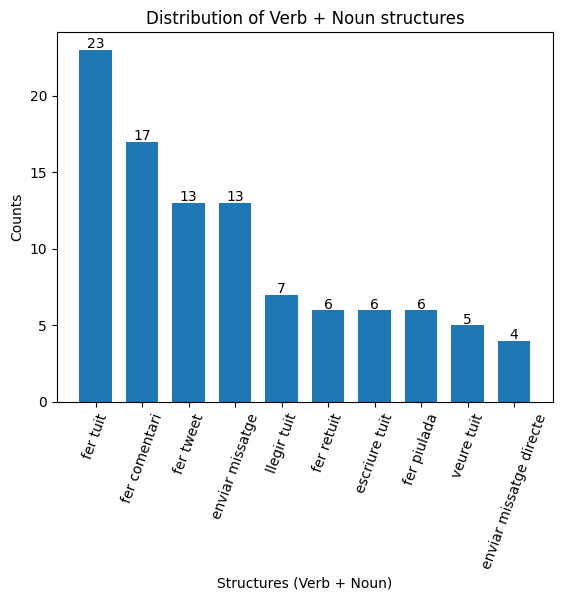

In [ ]:
# Create a bar chart to visualize the top 10 structures
fig, ax = plt.subplots()
ax.bar(top_struct_lab, top_struct_val, width=0.7)
for i in range(len(top_struct_lab)):
        plt.text(i, top_struct_val[i]+0.1, top_struct_val[i], ha='center')
plt.title("Distribution of Verb + Noun structures")
plt.xlabel("Structures (Verb + Noun)")
plt.ylabel("Counts")
ax.tick_params(axis='x', labelrotation=70)

In [ ]:
# Export to csv all the unique structures to manually chech if they are light verb constructions or not
df_lvc_ann = df_verb_constr['verb_structure'].drop_duplicates()
df_lvc_ann.to_csv(folderName+"LVC_to_annotate.csv")

In [ ]:
# Load the annotated LVC file
df_lvc_ann = pd.read_csv(folderName+"LVC_annotation.csv", sep=";")
print(df_lvc_ann.shape)
df_lvc_ann.head()

(139, 2)


,constructions,is_LVC
0,fer tuit,1
1,fer comentari,1
2,fer tweet,1
3,enviar missatge,0
4,llegir tuit,0


In [ ]:
# How many distinct constructions are light verb constructions & percentage
df_lvc_ann[df_lvc_ann['is_LVC'] == 1].shape
print('Number of lemmatized LVC:', df_lvc_ann[df_lvc_ann['is_LVC'] == 1].shape[0])
print(f'% LVC out of all verb constr: {round(df_lvc_ann[df_lvc_ann['is_LVC'] == 1].shape[0]*100/df_lvc_ann['is_LVC'].shape[0],ndigits=1)}')

Number of lemmatized LVC: 21
% LVC out of all verb constr: 15.1


In [ ]:
# Merge this annotation with the big dataframe for all verbal constructions
df_verb_constr = pd.merge(df_verb_constr, df_lvc_ann, left_on='verb_structure', right_on='constructions', how='left')
df_verb_constr.drop(columns='constructions', axis = 1, inplace=True)
df_verb_constr.head()

,id,searchQuery,text,timestamp,cleanText,foundWord,socialMediaSense,original_lemma,loanword_lemma,loanword_form,...,tokenized,pos_tags,detected_pos,year_month,verb_constr,verb_form,verb_lemma,verb_lemma_constr,verb_structure,is_LVC
0,1620116848825217024,retuit,et segueixo i no puc fer retuit a les teves pi...,2023-01-30 17:48:00+00:00,et segueixo i no puc fer retuit a les teves pi...,retuit,1,retweet,retuit,retuit,...,"[et, segueixo, i, no, puc, fer, retuit, a, les...","[pron, verb, cconj, adv, aux, verb, noun, adp,...",noun,2023-01,fer retuit,Inf,fer,fer retuit,fer retuit,1
1,1718544104508838085,respostes,imaginem una ia que sigui capaç de simular les...,2023-10-29T08:23:00.000Z,imaginem una ia que sigui capaç de simular les...,respostes,1,reply,resposta,respostes,...,"[imaginem, una, ia, que, sigui, capaç, de, sim...","[verb, det, noun, pron, aux, adj, adp, verb, d...",noun,2023-10,simular les respostes,Inf,simular,simular les respostes,simular resposta,0
2,1718651703115842033,likes,puigdemontistes titllant de cunyat a ningú 🤣🤣🤣...,2023-10-29T15:31:00.000Z,puigdemontistes titllant de cunyat a ningú 🤣🤣🤣...,likes,1,like,like,likes,...,"[puigdemontistes, titllant, de, cunyat, a, nin...","[adj, verb, adp, noun, adp, pron, pron, verb, ...",noun,2023-10,arreplegar likes,Inf,arreplegar,arreplegar likes,arreplegar like,0
3,1652346629607903241,tuits,"sempre ho dic, tinc molta capacitat per escriu...",2023-04-29T16:18:00.000Z,"sempre ho dic, tinc molta capacitat per escriu...",tuits,1,tweet,tuit,tuits,...,"[sempre, ho, dic, ,, tinc, molta, capacitat, p...","[adv, pron, verb, punct, verb, det, noun, adp,...",noun,2023-04,escriure tuits,Inf,escriure,escriure tuits,escriure tuit,0
4,1619962362446086144,tweet,ha arribat el dia de fer el titular cutre que ...,2023-01-30 07:34:00+00:00,ha arribat el dia de fer el titular cutre que ...,tweet,1,tweet,tweet,tweet,...,"[ha, arribat, el, dia, de, fer, el, titular, c...","[aux, verb, det, noun, adp, verb, det, noun, a...",noun,2023-01,fer aquest tweet,Inf,fer,fer aquest tweet,fer tweet,1


In [ ]:
# Now we can see how many LVC we have in the data and which are the most frequent
print('Number of LVC lemmas in the data:', df_verb_constr[df_verb_constr['is_LVC'] == 1].shape[0])
count_lvc_lemmas = Counter(df_verb_constr[df_verb_constr['is_LVC'] == 1]['verb_structure'])
count_lvc_lemmas.most_common(5)

Number of LVC lemmas in the data: 84


[('fer tuit', 23),
 ('fer comentari', 17),
 ('fer tweet', 13),
 ('fer retuit', 6),
 ('fer piulada', 6)]

In [ ]:
# How many different LVCs we have with inflection
print('Number of inflected LVCs: ', len(df_verb_constr[df_verb_constr['is_LVC'] == 1]['verb_constr'].unique()))

Number of inflected LVCs:  53


In [ ]:
# Number of different verb lemmas that are used in LVCs
print('Number of unique verb lemmas in LVC: ', len(df_verb_constr[df_verb_constr['is_LVC'] == 1]['verb_lemma'].unique()))
print('Unique light verbs from LVCs:', list(Counter(df_verb_constr[df_verb_constr['is_LVC'] == 1]['verb_lemma']).keys()))

# Which nouns (lemma) are more frequenty combined into LVCs
count_noun_lvc = dict(sorted(Counter(df_verb_constr[df_verb_constr['is_LVC'] == 1]['loanword_lemma']).items(), key=lambda item: item[1], reverse=True))
print('Frequency of occurrence of the lemmas of nouns in LVCs')
for verb, count in zip(count_noun_lvc.keys(), count_noun_lvc.values()):
    percentage = np.round(count*100/np.sum(list(count_noun_lvc.values())), decimals=1)
    print(f' {verb}: {count} ({percentage}%)')

Number of unique verb lemmas in LVC:  6
Unique light verbs from LVCs: ['fer', 'tenir', 'donar', 'deixar', 'posar', 'fotre']
Frequency of occurrence of the lemmas of nouns in LVCs
 tuit: 25 (29.8%)
 comentari: 18 (21.4%)
 tweet: 14 (16.7%)
 retuit: 7 (8.3%)
 piulada: 6 (7.1%)
 like: 6 (7.1%)
 seguidor: 3 (3.6%)
 m'agrada: 1 (1.2%)
 post: 1 (1.2%)
 resposta: 1 (1.2%)
 amic: 1 (1.2%)
 publicació: 1 (1.2%)


**FIND INFLECTED (MORPH) VERBAL FORMS**

In [ ]:
# Find the amount of verbs from the list (we include the detected_pos but allow some wiggle room for the English words and some normal errors of the tool, like participles)
df_morph_verbs = df[(df['loanword_pos'].str.contains('verb')) & (df['loanword_features'].isin(['infinitive', '', 'participle', 'gerund', 'lemma'])) & (df['detected_pos'].isin(['verb', '', 'adj', 'aux']))]
df_morph_verbs.shape

(1010, 18)

In [ ]:
# Find the number of occurrences removing duplicated forms
print('Number of unique verbal forms (inflected):', df_morph_verbs.drop_duplicates(subset='foundWord').shape[0])

# Find the number of occurrences removing duplicated lemmas
print('Number of unique verbal lemmas:', df_morph_verbs.drop_duplicates(subset='loanword_lemma').shape[0])

Number of unique verbal forms (inflected): 49
Number of unique verbal lemmas: 25


**MOST FREQUENT LEMMAS IN CATALAN AND ENGLISH**

In [ ]:
# Most common lemmas in Catalan (top 5)
loanword_lemmas = Counter(df['loanword_lemma']).most_common(10)
print('Frequency of occurrence of the lemmas of all the loanwords')
for verb, count in loanword_lemmas:
    percentage = np.round(count*100/df['loanword_lemma'].shape[0], decimals=1)
    print(f' {verb}: {count} ({percentage}%)')

Frequency of occurrence of the lemmas of all the loanwords
 tuit: 398 (13.7%)
 comentari: 236 (8.1%)
 compartir: 203 (7.0%)
 tweet: 193 (6.6%)
 piulada: 176 (6.1%)
 blocar: 168 (5.8%)
 seguidor: 143 (4.9%)
 missatge: 136 (4.7%)
 publicar: 135 (4.6%)
 perfil: 134 (4.6%)


In [ ]:
# Most common lemmas from the original English words
eng_lemmas = Counter(df['original_lemma']).most_common(10)
print('Frequency of occurrence of the lemmas of all the loanwords')
for verb, count in eng_lemmas:
    percentage = np.round(count*100/df['original_lemma'].shape[0], decimals=1)
    print(f' {verb}: {count} ({percentage}%)')

Frequency of occurrence of the lemmas of all the loanwords
 tweet: 863 (29.7%)
 comment: 339 (11.7%)
 block: 260 (8.9%)
 post: 225 (7.7%)
 share: 203 (7.0%)
 follower: 144 (5.0%)
 message: 136 (4.7%)
 profile: 134 (4.6%)
 reply: 105 (3.6%)
 like: 94 (3.2%)


In [ ]:
# Filter the dataframe to keep only the rows with any non-finite verbal form
df_infl_verbs = df_morph_verbs[df_morph_verbs['loanword_features'] != 'lemma']
df_infl_verbs.shape

In [ ]:
# For verbs, which form is the most productive? (check if all 3 non-fin forms are represented)
# Count the number of instances of each 'loanword_features' value for each 'loanword_lemma'
lemma_feature_counts = df_infl_verbs.groupby('loanword_lemma')['loanword_features'].value_counts().unstack(fill_value=0)
print(lemma_feature_counts)

loanword_features  gerund  infinitive  participle
loanword_lemma                                   
blocar                  7          54         105
bloquejar               4          23          37
clavar                  0           1           0
comentar               15          55          27
compartir              18         154          31
deixar de seguir        0           8           0
etiquetar               1          20           8
piular                  3          50           7
prohibir                0           3           1
publicar               11          97          27
repiular                1           8           6
republicar              0           0           1
respondre               0          31           0
retuitar                0          10           0
retuitejar              0           4           0
seguir                  9          58           9
silenciar               1          23           6
tuitar                  0           4           0


**CASE STUDY 2: HOW THE ENGLISH WORD 'TWEET' IS USED IN CATALAN**

In [ ]:
# First for nouns (use lemmas)
df_tweet_noun = df[(df['original_lemma'] == 'tweet') & (df['loanword_pos'].str.contains('noun')) & (df['detected_pos'].isin(['noun', 'propn', '']))]
print(df_tweet_noun.shape)
tweets_noun = Counter(df_tweet_noun['loanword_lemma'])
print(tweets_noun)

(767, 18)
Counter({'tuit': 392, 'tweet': 191, 'piulada': 176, 'piulet': 8})


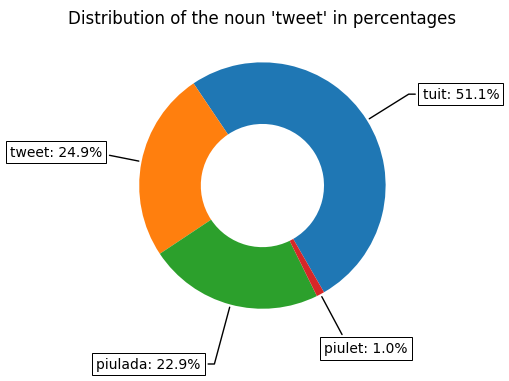

In [ ]:
# Data for the pie chart
tweet_n_labels = list(tweets_noun.keys())
tweet_n_values = list(tweets_noun.values())

def percentage(val, allvals):
    absolute = np.round(val * 100. / float(np.sum(allvals)), decimals=1)
    return f"{absolute:.1f}%"

percentages = [percentage(v, tweet_n_values) for v in tweet_n_values]

fig, ax = plt.subplots(figsize=(7, 4), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(tweet_n_values, startangle=-60, wedgeprops=dict(width=0.5), pctdistance=0.8)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    # Adjust label positions to avoid overlaps for small slices
    # For the smallest slices (last two), push labels further out and slightly shift vertically
    if i >= len(wedges) - 2:
        ax.annotate(
            f'{tweet_n_labels[i]}: {percentages[i]}',
            xy=(x, y),
            xytext=(0.5 * np.sign(x), 1.5 * y),
            horizontalalignment=horizontalalignment,
            **kw
        )
    else:
        ax.annotate(
            f'{tweet_n_labels[i]}: {percentages[i]}',
            xy=(x, y),
            xytext=(1.3 * np.sign(x), 1.4 * y),
            horizontalalignment=horizontalalignment,
            **kw
        )

plt.title("Distribution of the noun 'tweet' in percentages")
plt.show()

In [ ]:
# Then for verbs (use lemmas)
df_tweet_verb = df[(df['original_lemma'] == 'tweet') & (df['loanword_pos'].str.contains('verb')) & (df['detected_pos'].isin(['verb', 'adj', '']))]
print(df_tweet_verb.shape)
tweets_verb = Counter(df_tweet_verb['loanword_lemma'])
print(tweets_verb)

(90, 18)
Counter({'piular': 60, 'tuitejar': 24, 'tuitar': 4, 'tweet': 2})


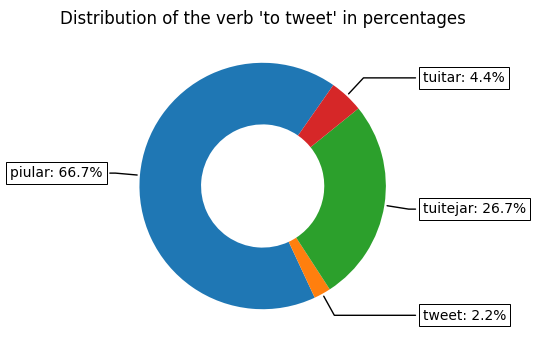

In [ ]:
# Data for the pie chart
tweet_v_labels = list(tweets_verb.keys())
tweet_v_values = list(tweets_verb.values())

def percentage(val, allvals):
    absolute = np.round(val * 100. / float(np.sum(allvals)), decimals=1)
    return f"{absolute:.1f}%"

percentages = [percentage(v, tweet_v_values) for v in tweet_v_values]

fig, ax = plt.subplots(figsize=(7, 4), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(tweet_v_values, startangle=55, wedgeprops=dict(width=0.5), pctdistance=0.8)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    # Adjust label positions to avoid overlaps for small slices
    # For the smallest slices (last two), push labels further out and slightly shift vertically
    ax.annotate(
        f'{tweet_v_labels[i]}: {percentages[i]}',
        xy=(x, y),
        xytext=(1.3 * np.sign(x), 1.2 * y),
        horizontalalignment=horizontalalignment,
        **kw
    )

plt.title("Distribution of the verb 'to tweet' in percentages")
plt.show()

In [ ]:
# Find the proportion of categories and types for the tweet noun and verb
print("Proportion of categories for 'tweet' as noun:", np.round(df_tweet_noun['loanword_category'].value_counts(normalize=True) * 100, decimals=1))
print('-----')
print("Proportion of types for 'tweet' as noun:", np.round(df_tweet_noun['loanword_type'].value_counts(normalize=True) * 100, decimals=1))
print('------------------------------------')
print('------------------------------------')
print("Proportion of categores for 'tweet' as verb:", np.round(df_tweet_verb['loanword_category'].value_counts(normalize=True) * 100, decimals=1))
print('-----')
print("Proportion of types for 'tweet' as verb:", np.round(df_tweet_verb['loanword_type'].value_counts(normalize=True) * 100, decimals=1))

Proportion of categories for 'tweet' as noun: loanword_category
foreign lexeme    76.0
native lexeme     24.0
Name: proportion, dtype: float64
-----
Proportion of types for 'tweet' as noun: loanword_type
full adaptation     51.1
direct borrowing    24.9
calque              24.0
Name: proportion, dtype: float64
------------------------------------
------------------------------------
Proportion of categores for 'tweet' as verb: loanword_category
native lexeme     66.7
foreign lexeme    33.3
Name: proportion, dtype: float64
-----
Proportion of types for 'tweet' as verb: loanword_type
calque              66.7
full adaptation     31.1
direct borrowing     2.2
Name: proportion, dtype: float64
